<a href="https://colab.research.google.com/github/jdeiros/soa-2020/blob/master/HPC/Deiros_Jeronimo_ejercicio_2.gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Introducción
El siguiente ejemplo modifica el color de una imágen parametrizada, aplicando un filtro Sepia. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (rojo)-G(verde)-B(azul), de cada pixel.
Se utilizó el siguiente calculo para obtener los valores de cada color.
tr = 0.393R + 0.769G + 0.189B
tg = 0.349R + 0.686G + 0.168B
tb = 0.272R + 0.534G + 0.131B
donde tr, tg, y tb son los valores nuevos de cada color.

EL objetivo es aprender el funcionamiento del Lenguaje Python, CUDA y el manejo de imagenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.

#2 Armado del ambiente
Toma la direccion web de una imagen con acceso público en internet, la deja disponible al contexto de ejecucion del cuaderno colab.

In [1]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2020-11-21 18:03:41--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2020-11-21 18:03:41--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2020-11-21 18:03:41--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/jpeg]


#2.2 Instala en el cuaderno el módulo CUDA de Python.


In [2]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 28.0MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=ba85855b47b1922953bdbe6c11c9e81bf4c726cd3f79a4e6901e2c60a4741808
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=7e2944d7b69ff97ccb08b1e00f4e2a5696a0a19441af58f2e5887c3073575d09
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


#3 Desarrollo
Ejecución del algoritmo filtro sepia en GPU.

Imagen del filtro: imagen.jpg -RGB- [768, 1024]
Thread: [ 16 , 19  ], Bloque : [ 48 , 54 ]
Total de Thread: [ 768 , 1026  ]  =  787968
Tiempo TOTAL:  55.635 [ms]
Tiempo GPU  :  0.13 [ms]


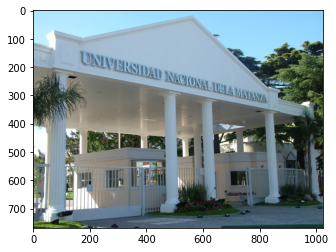

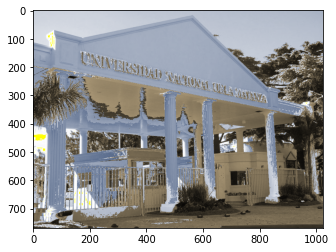

In [9]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------
try:
  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre ) 
    
  # summarize some details about the image 
  img_alto, img_ancho = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_R_cpu = numpy.empty_like( img_O_cpu)

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R )
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    
    float r = 0.0;
    float g = 0.0;
    float b = 0.0;


    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      // Calculo el color gris para el pixel a partir de los componentes.
      r = (float)img_O[(idx+(idy*ancho))*3    ]*0.393;  // Componente Rojo del pixel.
      r +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.769;  // Componente Verde del pixel.
      r +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.189;   // Componente Azul del pixel.
      
      g = (float)img_O[(idx+(idy*ancho))*3    ]*0.349;  // Componente Rojo del pixel.
      g +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.686;  // Componente Verde del pixel.
      g +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.168;   // Componente Azul del pixel.

      b = (float)img_O[(idx+(idy*ancho))*3    ]*0.272;  // Componente Rojo del pixel.
      b +=(float)img_O[((idx+(idy*ancho))*3)+1]*0.534;  // Componente Verde del pixel.
      b +=(float)img_O[((idx+(idy*ancho))*3)+2]*0.131;   // Componente Azul del pixel.

      // Escribo el color del pixel.
      img_R[(idx+(idy*ancho))*3  ] = (char) r;
      img_R[(idx+(idy*ancho))*3+1] = (char) g;
      img_R[(idx+(idy*ancho))*3+2] = (char) b;
    }
  }
  """) 

  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  tiempo_img = datetime.now()

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 19
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_img = datetime.now()

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_img = datetime.now() - tiempo_img

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

except Exception as e:
  print(f"error: {e}")